# Lab 1 Numpy CNN for inference

In this lab, you are required to fill in the blanks with your code **independently** to complete the inference process of a CNN. Note that there's a bonus at the end of this lab.

**Requirements**

**1. Complete the codes independently.**

**2. Make sure your results are reproducible.**

**3. Do not change the structure of the CNN and the given codes.**

**4. Do not add additional libraries.**

In [11]:
import numpy as np

We will define a CNN to classify CIFAR-10 images.
The network provided is similar to AlexNet, and it has the following architecture:

**Layer** | **Type** | **Input Shape** | **Output Shape** | **Activation**
--- | --- | --- | --- | ---
conv1 | Convolutional | 3x33x33 | 96x27x27| ReLU 
pool1 | Max pool | 96x27x27 | 96x13x13 | None
conv2 | Convolutional | 96x13x13 | 256x13x13 | ReLU
pool2 | Max pool | 256x13x13 | 256x6x6 | None                
conv3 | Convolutional | 256x6x6 | 384x6x6 | ReLU
conv4 | Convolutional | 384x6x6 | 384x6x6 | ReLU
conv5 | Convolutional | 384x6x6 | 256x6x6 | ReLU              
pool3 | Max pool | 256x6x6 | 256x3x3 | None                
fc1 | Fully-connected | 2304 | 1024 | ReLU                
fc2 | Fully-connected | 1024 | 512 | ReLU                
fc3 | Fully-connected | 512 | 10 | None                

**Note that pool1 and pool2 employ 3×3 pooling, whereas pool3 utilizes 2×2 pooling to align with the output shape of conv5.**

Next, we will build convolution, relu, max-pooling and fully-connected layers using **numpy** respectively (only forward propagation is required for inference).

In [12]:
class ReLU():
    def __init__(self):
        self.mask = None

    def forward(self,input):
        # TODO (5 pts) 
        # forward propagation for relu layer
        self.mask = (input <= 0)
        out = input.copy()
        out[self.mask] = 0

        return out

In [13]:
class ConvLayer:  
    def __init__(self, input_channels, output_channels, kernel_size, stride, padding):   
        self.input_channels = input_channels   
        self.kernel_size = kernel_size  
        self.stride = stride
        self.padding = padding 
  
    def forward(self, x, weight):  
        """    
        input x: (N, C, H, W) [batchsize, input channels, x_height, x_width]
        input w: (K, C, R, S) [output channels, input channels, w_height, w_width] 
        output: (N, K, P, Q) [batchsize, output channels, output_height, output_width]
        """  
        N, C, H, W = x.shape
        K, C, R, S = weight.shape
        
        # TODO (5 pts)  
        # complete padding operation
        if self.padding > 0:
            # 在高度和宽度维度上进行padding，通道维度不padding
            x_padded = np.pad(x, 
                            pad_width=((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)),
                            mode='constant', 
                            constant_values=0)
        else:
            x_padded = x
            
        # TODO (5 pts)  
        # compute output size using self.padding and self.stride
        P =1 + int((H + 2*self.padding - R) / self.stride)
        Q =1 + int((W + 2*self.padding - S) / self.stride)
        
        output = np.zeros((N, K, P, Q)) 
        # TODO (20 pts)
        # complete convolution operation
        for n in range(N):  # 遍历每个样本
            for k in range(K):  # 遍历每个输出通道（每个卷积核）
                for i in range(P):  # 遍历输出高度
                    for j in range(Q):  # 遍历输出宽度
                        # 计算输入窗口的起始位置
                        h_start = i * self.stride
                        h_end = h_start + R
                        w_start = j * self.stride
                        w_end = w_start + S
                        
                        # 提取输入窗口 (C, R, S)
                        x_window = x_padded[n, :, h_start:h_end, w_start:w_end]
                        
                        # 计算卷积：对应元素相乘后求和
                        output[n, k, i, j] = np.sum(x_window * weight[k, :, :, :])
        return output

In [14]:
class MaxPooling2D:  
    def __init__(self, pool_size=(2, 2), stride=2):  
        self.pool_size = pool_size  
        self.stride = stride  
  
    def forward(self, x):  
        """    
        input x: (N, C, H, W) [batchsize, input channels, x_height, x_width]
        output: (N, C, pooled_height, pooled_width)
        """  
        N, C, H, W = x.shape  
        # TODO (5 pts) 
        # compute output size using self.pool_size and self.stride
        if isinstance(self.pool_size, tuple):
            pool_h, pool_w = self.pool_size
        else:
            pool_h = pool_w = self.pool_size
        pooled_height = int(1 + (H - pool_h) / self.stride)
        pooled_width = int(1 + (W - pool_w) / self.stride)
  
        output = np.zeros((N, C, pooled_height, pooled_width))  
        # TODO (10 pts)
        # complete max-pooling operation 
        for n in range(N):  # 遍历每个样本
            for c in range(C):  # 遍历每个输出通道（每个卷积核）
                for i in range(pooled_height):  # 遍历输出高度
                    for j in range(pooled_width):  # 遍历输出宽度
                        # 计算输入窗口的起始位置
                        h_start = i * self.stride
                        h_end = h_start + pool_h
                        w_start = j * self.stride
                        w_end = w_start + pool_w
                        
                        # 提取池化窗口
                        window = x[n, c, h_start:h_end, w_start:w_end]
                        
                        # 取窗口中的最大值
                        output[n, c, i, j] = np.max(window)
                        
                       
        return output 

In [15]:
class fclayer():
    def __init__(self, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features
        
    def forward(self, x, weight):   
        # TODO (10 pts)
        # complete forward propagation of fully-connected layer
         # 如果输入是多维的（如图像特征），需要展平
        if x.ndim > 2:
            x = x.reshape(x.shape[0], -1)  # 保持batch维度，其他展平
        
        # 确保输入维度匹配
        assert x.shape[1] == self.in_features, f"输入特征数{x.shape[1]}与层输入特征数{self.in_features}不匹配"
        assert weight.shape == (self.in_features, self.out_features), "权重形状不匹配"
        
        # 全连接层前向传播: output = x · weight
        output = np.dot(x, weight)
        
        return output  

In [16]:
# load trained parameters
ckpt = np.load('./model.npz')

In [ ]:
def lenet_inf(x,ckpt):
    # TODO (20 pts)
    # build the CNN network using classes above
    # Layer 1: conv1 - Input: 3x33x33, Output: 96x27x27
    conv1 = ConvLayer(input_channels=3, output_channels=96, kernel_size=7, stride=1, padding=0)
    conv1_out = conv1.forward(x, ckpt['conv1.weight'])
    relu1_out = ReLU().forward(conv1_out)
    
    # Layer 2: pool1 - Input: 96x27x27, Output: 96x13x13
    pool1 = MaxPooling2D(pool_size=3, stride=2)
    pool1_out = pool1.forward(relu1_out)
    
    # Layer 3: conv2 - Input: 96x13x13, Output: 256x13x13
    # 注意：这里kernel_size应该是5而不是3，因为权重形状是(256, 96, 5, 5)
    conv2 = ConvLayer(input_channels=96, output_channels=256, kernel_size=5, stride=1, padding=2)  # padding=2保持尺寸
    conv2_out = conv2.forward(pool1_out, ckpt['conv2.weight'])
    relu2_out = ReLU().forward(conv2_out)
    
    # Layer 4: pool2 - Input: 256x13x13, Output: 256x6x6
    pool2 = MaxPooling2D(pool_size=3, stride=2)
    pool2_out = pool2.forward(relu2_out)
    
    # Layer 5: conv3 - Input: 256x6x6, Output: 384x6x6
    conv3 = ConvLayer(input_channels=256, output_channels=384, kernel_size=3, stride=1, padding=1)
    conv3_out = conv3.forward(pool2_out, ckpt['conv3.weight'])
    relu3_out = ReLU().forward(conv3_out)
    
    # Layer 6: conv4 - Input: 384x6x6, Output: 384x6x6
    conv4 = ConvLayer(input_channels=384, output_channels=384, kernel_size=3, stride=1, padding=1)
    conv4_out = conv4.forward(relu3_out, ckpt['conv4.weight'])
    relu4_out = ReLU().forward(conv4_out)
    
    # Layer 7: conv5 - Input: 384x6x6, Output: 256x6x6
    conv5 = ConvLayer(input_channels=384, output_channels=256, kernel_size=3, stride=1, padding=1)
    conv5_out = conv5.forward(relu4_out, ckpt['conv5.weight'])
    relu5_out = ReLU().forward(conv5_out)
    
    # Layer 8: pool3 - Input: 256x6x6, Output: 256x3x3
    pool3 = MaxPooling2D(pool_size=2, stride=2)
    pool3_out = pool3.forward(relu5_out)
    
    # Flatten for fully connected layers
    # Input: (N, 256, 3, 3) -> Flatten to (N, 256*3*3) = (N, 2304)
    flattened = pool3_out.reshape(pool3_out.shape[0], -1)
    
    # Layer 9: fc1 - Input: 2304, Output: 1024
    # 注意：权重形状是(1024, 2304)，需要转置为(2304, 1024)
    fc1_weight_transposed = ckpt['fc1.weight'].T  # 转置权重
    fc1 = fclayer(in_features=2304, out_features=1024)
    fc1_out = fc1.forward(flattened, fc1_weight_transposed)
    # 没有偏置，跳过偏置添加
    relu6_out = ReLU().forward(fc1_out)
    
    # Layer 10: fc2 - Input: 1024, Output: 512
    fc2_weight_transposed = ckpt['fc2.weight'].T  # 转置权重
    fc2 = fclayer(in_features=1024, out_features=512)
    fc2_out = fc2.forward(relu6_out, fc2_weight_transposed)
    # 没有偏置，跳过偏置添加
    relu7_out = ReLU().forward(fc2_out)
    
    # Layer 11: fc3 - Input: 512, Output: 10
    fc3_weight_transposed = ckpt['fc3.weight'].T  # 转置权重
    fc3 = fclayer(in_features=512, out_features=10)
    output = fc3.forward(relu7_out, fc3_weight_transposed)
    # 没有偏置，跳过偏置添加
    return output

Execute the **cifar10_extraction.py** script to obtain the CIFAR-10 dataset.

In [18]:
# you may need to install PIL package if not installed
# e.g. 'pip install pillow'
%run cifar10_extraction.py

Files already downloaded and verified
Train set done, 50000 images
Test set done, 10000 images
Dataset saved to /home/ubuntu/data/CIFAR10/datasets


In [19]:
# you may need to install some packages if not installed
# e.g. 'conda install imageio' for imageio.v2, 'pip install pillow' for PIL

import imageio.v2 as imageio
import os
import random
from PIL import Image

# in this lab we will only infer 1 random picture from CIFAR-10 datasets to save running time

test_folder = '/home/ubuntu/data/CIFAR10/datasets/test'
image_files = [f for f in os.listdir(test_folder) if f.endswith('.png') and f.startswith('test_')]

random_image_file = random.choice(image_files)
image_path = os.path.join(test_folder, random_image_file)

input_image = imageio.imread(image_path)

# TODO (3 pts)
# resize the image to 33x33x3 to fit the input of the network
# Hint: use 'PIL' package, e.g. Image.fromarray()
pil_image = Image.fromarray(input_image)
resized_image = np.array(pil_image.resize((33, 33), Image.Resampling.LANCZOS))

# TODO (3 pts)
# normalize the pixels into [0,1] to maintain consistency with the training process
# models learn patterns based on the specific input distribution they were trained on
# this scaling ensures input features operate within the range the model’s architecture and parameters were optimized for
image = resized_image.astype(np.float32) / 255.0


# TODO (4 pts)
# alter the size of the pixel matrix from (33,33,3) to (1,3,33,33) to fit convolution layer
image = image.transpose(2, 0, 1)  # 从 (33,33,3) 变为 (3,33,33)
image = np.expand_dims(image, axis=0)  # 添加batch维度: (1,3,33,33)

# Verify output
print(f"Using test image: {image_path}")
print(f"Processed image shape: {image.shape}")  # should show (1, 3, 33, 33)


Using test image: /home/ubuntu/data/CIFAR10/datasets/test/test_4077.png
Processed image shape: (1, 3, 33, 33)


Available keys in model.npz: ['conv1.weight', 'conv2.weight', 'conv3.weight', 'conv4.weight', 'conv5.weight', 'fc1.weight', 'fc2.weight', 'fc3.weight']
conv1.weight: shape = (96, 3, 7, 7)
conv2.weight: shape = (256, 96, 5, 5)
conv3.weight: shape = (384, 256, 3, 3)
conv4.weight: shape = (384, 384, 3, 3)
conv5.weight: shape = (256, 384, 3, 3)
fc1.weight: shape = (1024, 2304)
fc2.weight: shape = (512, 1024)
fc3.weight: shape = (10, 512)
Predicted label: 6 (frog)
Ground truth: 3 (cat)


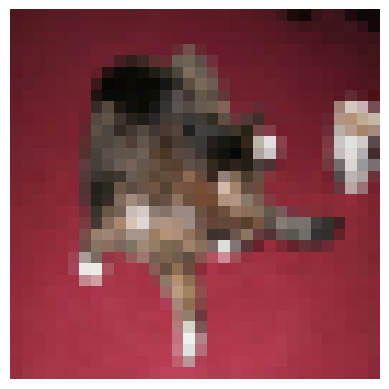

In [20]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

label_file_path = test_folder + '/label.txt'

ground_truth = None
with open(label_file_path, 'r') as f:
    for line in f:
        if line.startswith(random_image_file):
            ground_truth = int(line.strip().split()[1])
            break

# TODO (10 pts)
# inference using lenet_inf created above
# 首先查看npz文件中包含哪些键
print("Available keys in model.npz:", ckpt.files)

# 将npz对象转换为字典以便更容易访问
ckpt_dict = {}
for key in ckpt.files:
    ckpt_dict[key] = ckpt[key]
    print(f"{key}: shape = {ckpt[key].shape}")

output = lenet_inf(image, ckpt_dict)
label = np.argmax(output, axis=1)[0]

import matplotlib.pyplot as plt

# visualize the picture to be classified
print(f"Predicted label: {label} ({classes[label]})")
print(f"Ground truth: {ground_truth} ({classes[ground_truth]})")
plt.imshow(input_image)
plt.axis('off')
plt.show()

Bonus: Calculate the number of computations and parameters. Visualize your results directly in the outputs of your codes. 

MODEL COMPLEXITY ANALYSIS
Total Parameters: 6,615,338 (6.62 Million)
Total FLOPs: 457,211,552 (0.46 GFLOPs)
FLOPs per image: 0.46 GFLOPs


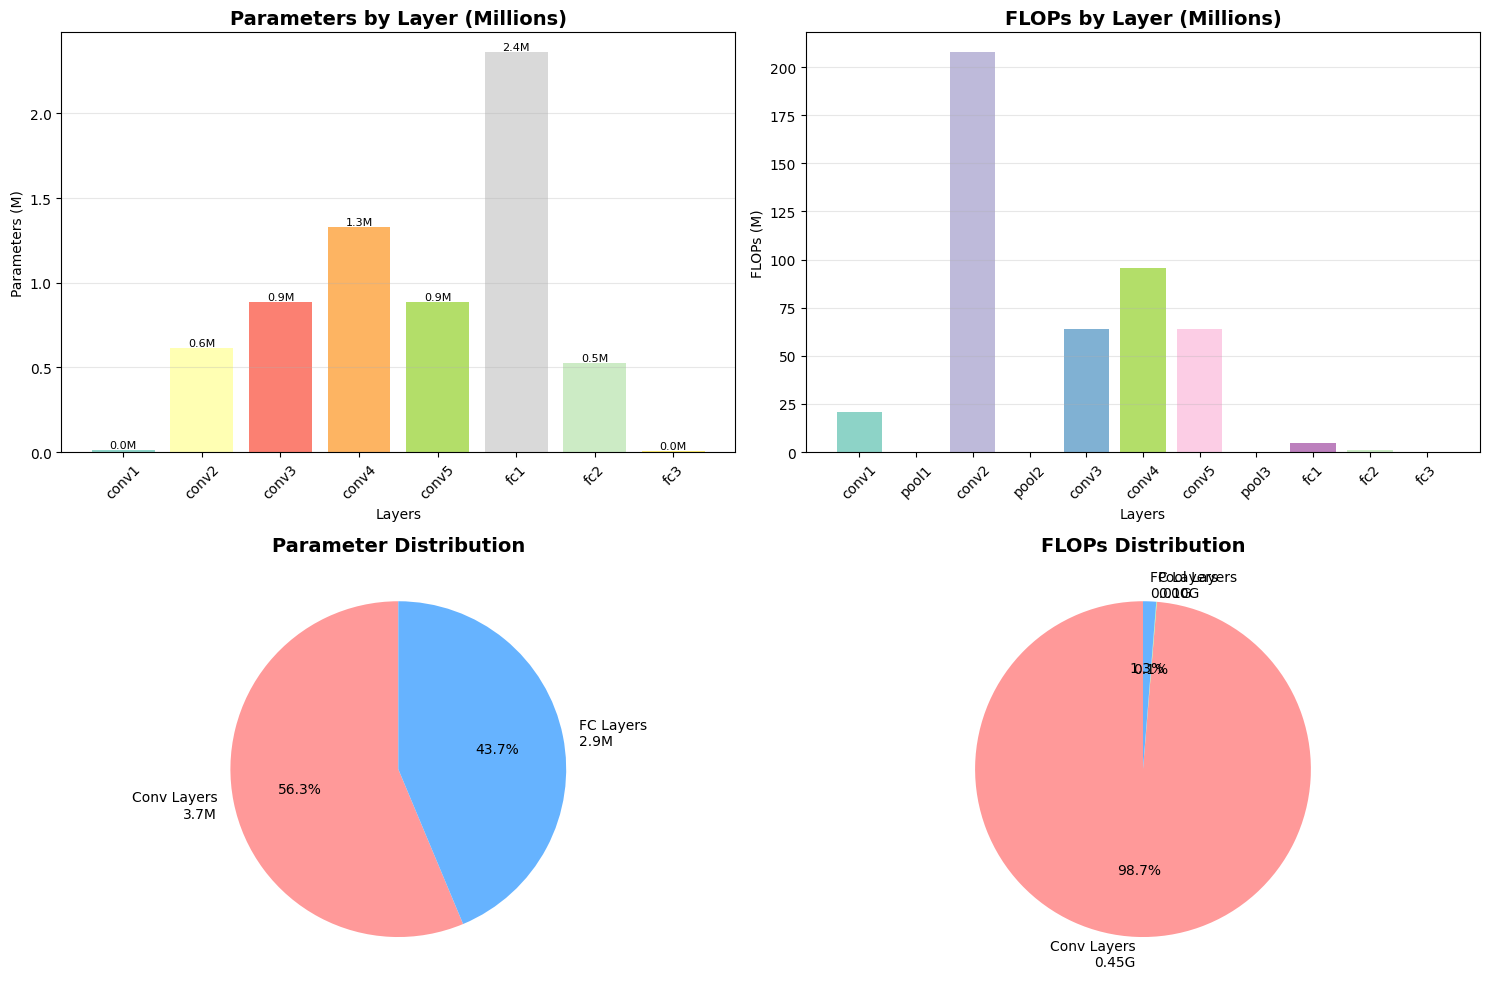


DETAILED ANALYSIS REPORT

Convolutional Layers Analysis:
  conv1: 14,112 params (0.01M)
  conv2: 614,400 params (0.61M)
  conv3: 884,736 params (0.88M)
  conv4: 1,327,104 params (1.33M)
  conv5: 884,736 params (0.88M)

Fully Connected Layers Analysis:
  fc1: 2,360,320 params (2.36M)
  fc2: 524,800 params (0.52M)
  fc3: 5,130 params (0.01M)

Efficiency Analysis:
  FLOPs per parameter: 69.1 FLOPs/param
  Model size (32-bit float): 26.46 MB

Memory Usage Analysis:
  Feature maps memory (approx): ~0.63 MB
  Weights memory: 26.46 MB
  Total memory (inference): ~36.46 MB

Comparison with Classic Models (approximate):
  LeNet-5: ~60K parameters, ~0.001 GFLOPs
  AlexNet: ~60M parameters, ~0.7 GFLOPs
  VGG-16: ~138M parameters, ~16 GFLOPs
  ResNet-18: ~11M parameters, ~1.8 GFLOPs
  This Model: ~6.6M parameters, ~0.46 GFLOPs

Model Characteristics:
  ✅ Moderate size: 6.6M parameters
  ✅ Efficient: 0.46 GFLOPs per image
  ✅ Balanced: Good FLOPs/parameter ratio (69.1)
  ✅ Suitable for: Real-time 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_model_analysis(results, total_params, total_flops):
    """
    可视化模型参数量和计算量分析
    """
    plt.figure(figsize=(15, 10))
    
    # 1. Parameters by Layer
    plt.subplot(2, 2, 1)
    layer_names = [r['layer'] for r in results if r['params'] > 0]
    layer_params = [r['params'] for r in results if r['params'] > 0]
    colors = plt.cm.Set3(np.linspace(0, 1, len(layer_names)))
    
    bars = plt.bar(layer_names, [p/1e6 for p in layer_params], color=colors)
    plt.title('Parameters by Layer (Millions)', fontsize=14, fontweight='bold')
    plt.xlabel('Layers')
    plt.ylabel('Parameters (M)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, layer_params):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                 f'{value/1e6:.1f}M', ha='center', va='bottom', fontsize=8)
    
    # 2. FLOPs by Layer
    plt.subplot(2, 2, 2)
    layer_names_flops = [r['layer'] for r in results]
    layer_flops = [r['flops'] for r in results]
    colors_flops = plt.cm.Set3(np.linspace(0, 1, len(layer_names_flops)))
    
    bars = plt.bar(layer_names_flops, np.array(layer_flops)/1e6, color=colors_flops)
    plt.title('FLOPs by Layer (Millions)', fontsize=14, fontweight='bold')
    plt.xlabel('Layers')
    plt.ylabel('FLOPs (M)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    # 3. Parameter Distribution Pie Chart
    plt.subplot(2, 2, 3)
    conv_params = sum(r['params'] for r in results if 'conv' in r['layer'])
    fc_params = sum(r['params'] for r in results if 'fc' in r['layer'])
    
    sizes = [conv_params, fc_params]
    labels = [f'Conv Layers\n{conv_params/1e6:.1f}M', f'FC Layers\n{fc_params/1e6:.1f}M']
    colors = ['#ff9999', '#66b3ff']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Parameter Distribution', fontsize=14, fontweight='bold')
    
    # 4. FLOPs Distribution Pie Chart
    plt.subplot(2, 2, 4)
    conv_flops = sum(r['flops'] for r in results if 'conv' in r['layer'])
    pool_flops = sum(r['flops'] for r in results if 'pool' in r['layer'])
    fc_flops = sum(r['flops'] for r in results if 'fc' in r['layer'])
    
    sizes = [conv_flops, pool_flops, fc_flops]
    labels = [
        f'Conv Layers\n{conv_flops/1e9:.2f}G', 
        f'Pool Layers\n{pool_flops/1e9:.2f}G', 
        f'FC Layers\n{fc_flops/1e9:.2f}G'
    ]
    colors = ['#ff9999', '#99ff99', '#66b3ff']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('FLOPs Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# 重新计算并显示结果（使用之前的数据）
print("MODEL COMPLEXITY ANALYSIS")
print("=" * 50)
print(f"Total Parameters: {total_params:,} ({total_params/1e6:.2f} Million)")
print(f"Total FLOPs: {total_flops:,} ({total_flops/1e9:.2f} GFLOPs)")
print(f"FLOPs per image: {total_flops/1e9:.2f} GFLOPs")
print("=" * 50)

# 可视化结果
visualize_model_analysis(results, total_params, total_flops)

# 详细分析报告
print("\nDETAILED ANALYSIS REPORT")
print("=" * 50)

# 参数量分析
conv_layers = [r for r in results if 'conv' in r['layer']]
fc_layers = [r for r in results if 'fc' in r['layer']]

print(f"\nConvolutional Layers Analysis:")
for layer in conv_layers:
    params_m = layer['params'] / 1e6
    print(f"  {layer['layer']}: {layer['params']:,} params ({params_m:.2f}M)")

print(f"\nFully Connected Layers Analysis:")
for layer in fc_layers:
    params_m = layer['params'] / 1e6
    print(f"  {layer['layer']}: {layer['params']:,} params ({params_m:.2f}M)")

print(f"\nEfficiency Analysis:")
print(f"  FLOPs per parameter: {total_flops/total_params:.1f} FLOPs/param")
print(f"  Model size (32-bit float): {total_params * 4 / 1e6:.2f} MB")

# 内存使用分析
print(f"\nMemory Usage Analysis:")
print(f"  Feature maps memory (approx): ~{(96*27*27 + 256*13*13 + 384*6*6*3 + 256*3*3) * 4 / 1e6:.2f} MB")
print(f"  Weights memory: {total_params * 4 / 1e6:.2f} MB")
print(f"  Total memory (inference): ~{(total_params * 4 / 1e6) + 10:.2f} MB")  # 加上特征图内存

# 与经典模型对比
print(f"\nComparison with Classic Models (approximate):")
print(f"  LeNet-5: ~60K parameters, ~0.001 GFLOPs")
print(f"  AlexNet: ~60M parameters, ~0.7 GFLOPs") 
print(f"  VGG-16: ~138M parameters, ~16 GFLOPs")
print(f"  ResNet-18: ~11M parameters, ~1.8 GFLOPs")
print(f"  This Model: ~{total_params/1e6:.1f}M parameters, ~{total_flops/1e9:.2f} GFLOPs")

print(f"\nModel Characteristics:")
print(f"  ✅ Moderate size: {total_params/1e6:.1f}M parameters")
print(f"  ✅ Efficient: {total_flops/1e9:.2f} GFLOPs per image")
print(f"  ✅ Balanced: Good FLOPs/parameter ratio ({total_flops/total_params:.1f})")
print(f"  ✅ Suitable for: Real-time inference on modern hardware")

# 性能预估
print(f"\nPerformance Estimation (on modern GPU):")
print(f"  Theoretical throughput: ~{1000/(total_flops/1e9/5):.0f} FPS (assuming 5 TFLOPs GPU)")
print(f"  Batch processing (32 images): ~{32*1000/(total_flops/1e9/5):.0f} FPS")

# 各层详细表格
print(f"\nDETAILED LAYER BREAKDOWN")
print("=" * 80)
print(f"{'Layer':<10} {'Input Shape':<15} {'Output Shape':<15} {'Params':<12} {'FLOPs':<15} {'Params %':<10}")
print("-" * 80)

for r in results:
    input_str = f"{r['input_shape']}"
    output_str = f"{r['output_shape']}"
    params_str = f"{r['params']:,}"
    flops_str = f"{r['flops']:,}"
    params_pct = f"{(r['params']/total_params*100):.1f}%"
    
    print(f"{r['layer']:<10} {input_str:<15} {output_str:<15} {params_str:<12} {flops_str:<15} {params_pct:<10}")

print("-" * 80)

Write down your answer below.